In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [5]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

# Load data and split

In [ ]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [7]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [8]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [9]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Network parameters

In [10]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [11]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Self Supervised Training

In [12]:
max_epochs = 100 if not os.getenv("CI", False) else 2 # 1000

In [13]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 7.44423 | val_0_unsup_loss_numpy: 6.148200035095215|  0:00:07s
epoch 5  | loss: 1.0867  | val_0_unsup_loss_numpy: 1.0998599529266357|  0:00:32s
epoch 10 | loss: 1.0589  | val_0_unsup_loss_numpy: 1.0521600246429443|  0:00:56s
epoch 15 | loss: 0.99804 | val_0_unsup_loss_numpy: 0.9623299837112427|  0:01:22s
epoch 20 | loss: 0.93994 | val_0_unsup_loss_numpy: 0.960640013217926|  0:01:47s
epoch 25 | loss: 0.92697 | val_0_unsup_loss_numpy: 0.9635199904441833|  0:02:12s

Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_0_unsup_loss_numpy = 0.9469000101089478


c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [14]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [15]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

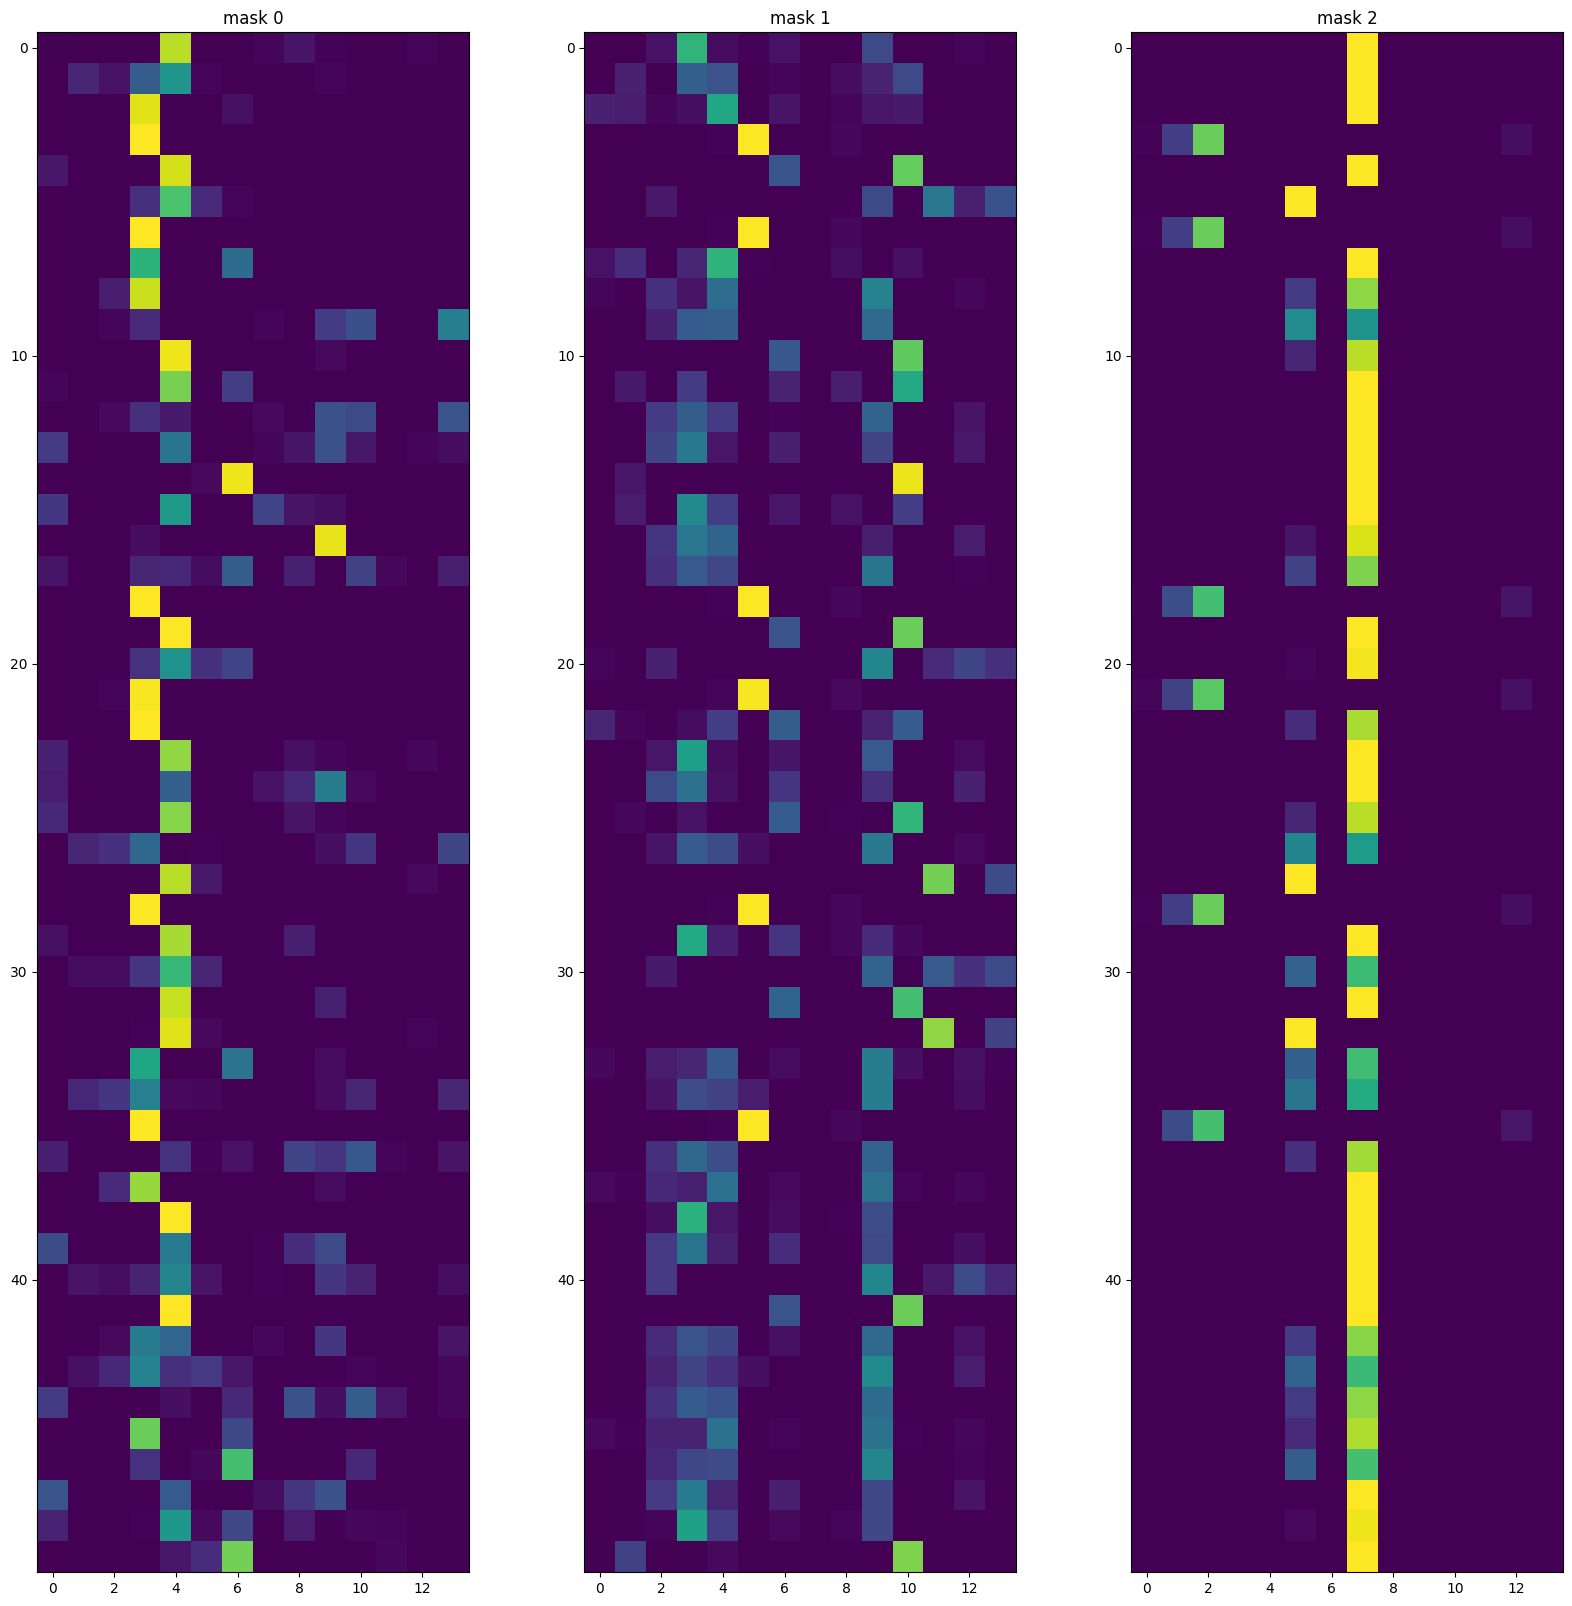

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


## Save and load the same way as other TabNet models

In [19]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip


# Training

In [20]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

In [21]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: cat_emb_dim changed from [] to [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
  warnings.warn(wrn_msg)
c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Us

epoch 0  | loss: 1.25941 | train_auc: 0.68755 | valid_auc: 0.68792 |  0:00:02s
epoch 5  | loss: 0.4613  | train_auc: 0.864   | valid_auc: 0.86825 |  0:00:13s
epoch 10 | loss: 0.43216 | train_auc: 0.88326 | valid_auc: 0.88274 |  0:00:25s
epoch 15 | loss: 0.42032 | train_auc: 0.89148 | valid_auc: 0.88828 |  0:00:36s
epoch 20 | loss: 0.40713 | train_auc: 0.89924 | valid_auc: 0.89319 |  0:00:47s
epoch 25 | loss: 0.39455 | train_auc: 0.90521 | valid_auc: 0.9005  |  0:00:57s
epoch 30 | loss: 0.38371 | train_auc: 0.90924 | valid_auc: 0.9022  |  0:01:15s
epoch 35 | loss: 0.37695 | train_auc: 0.91341 | valid_auc: 0.90575 |  0:01:38s
epoch 40 | loss: 0.36583 | train_auc: 0.91729 | valid_auc: 0.90952 |  0:01:55s
epoch 45 | loss: 0.36449 | train_auc: 0.92014 | valid_auc: 0.91152 |  0:02:06s
epoch 50 | loss: 0.35873 | train_auc: 0.92223 | valid_auc: 0.91461 |  0:02:17s
epoch 55 | loss: 0.3559  | train_auc: 0.92443 | valid_auc: 0.91652 |  0:02:39s
epoch 60 | loss: 0.35055 | train_auc: 0.92657 | vali

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


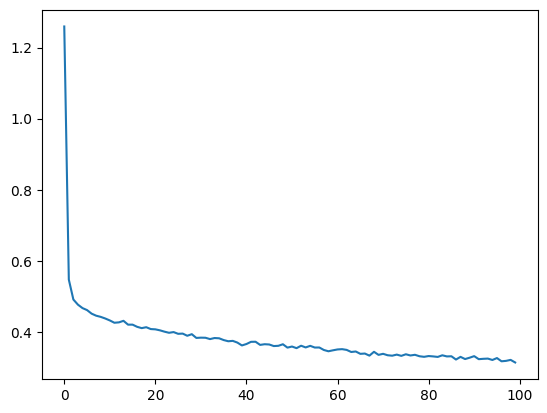

In [22]:
# plot losses
plt.plot(clf.history['loss'])

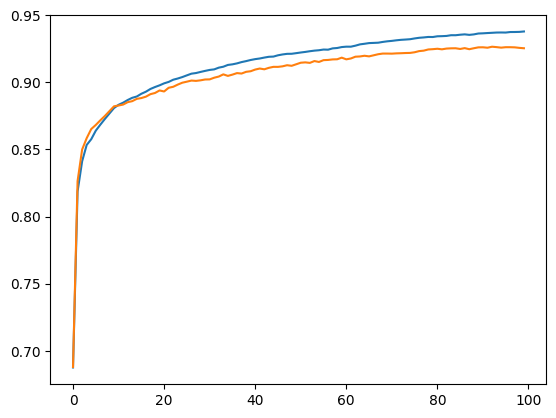

In [23]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

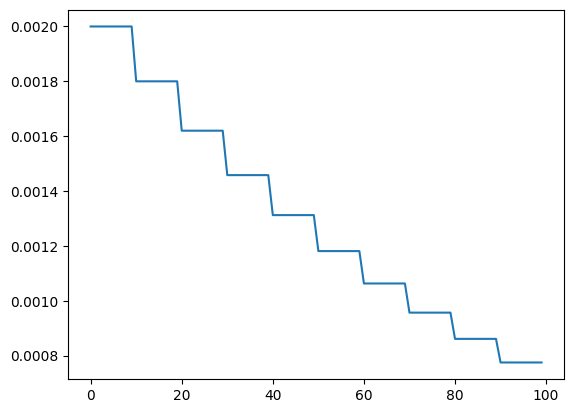

In [24]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [25]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9265337629211974
FINAL TEST SCORE FOR census-income : 0.9247640316225734


In [26]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

# Save and load Model

In [27]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [28]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [29]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9247640316225734


In [30]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [31]:
clf.feature_importances_

array([0.01299475, 0.00169913, 0.04672023, 0.06940042, 0.23422177,
       0.11462084, 0.02669943, 0.29438486, 0.0094204 , 0.03729725,
       0.06354722, 0.04954392, 0.01893261, 0.02051718])

# Local explainability and masks

In [32]:
explain_matrix, masks = clf.explain(X_test)

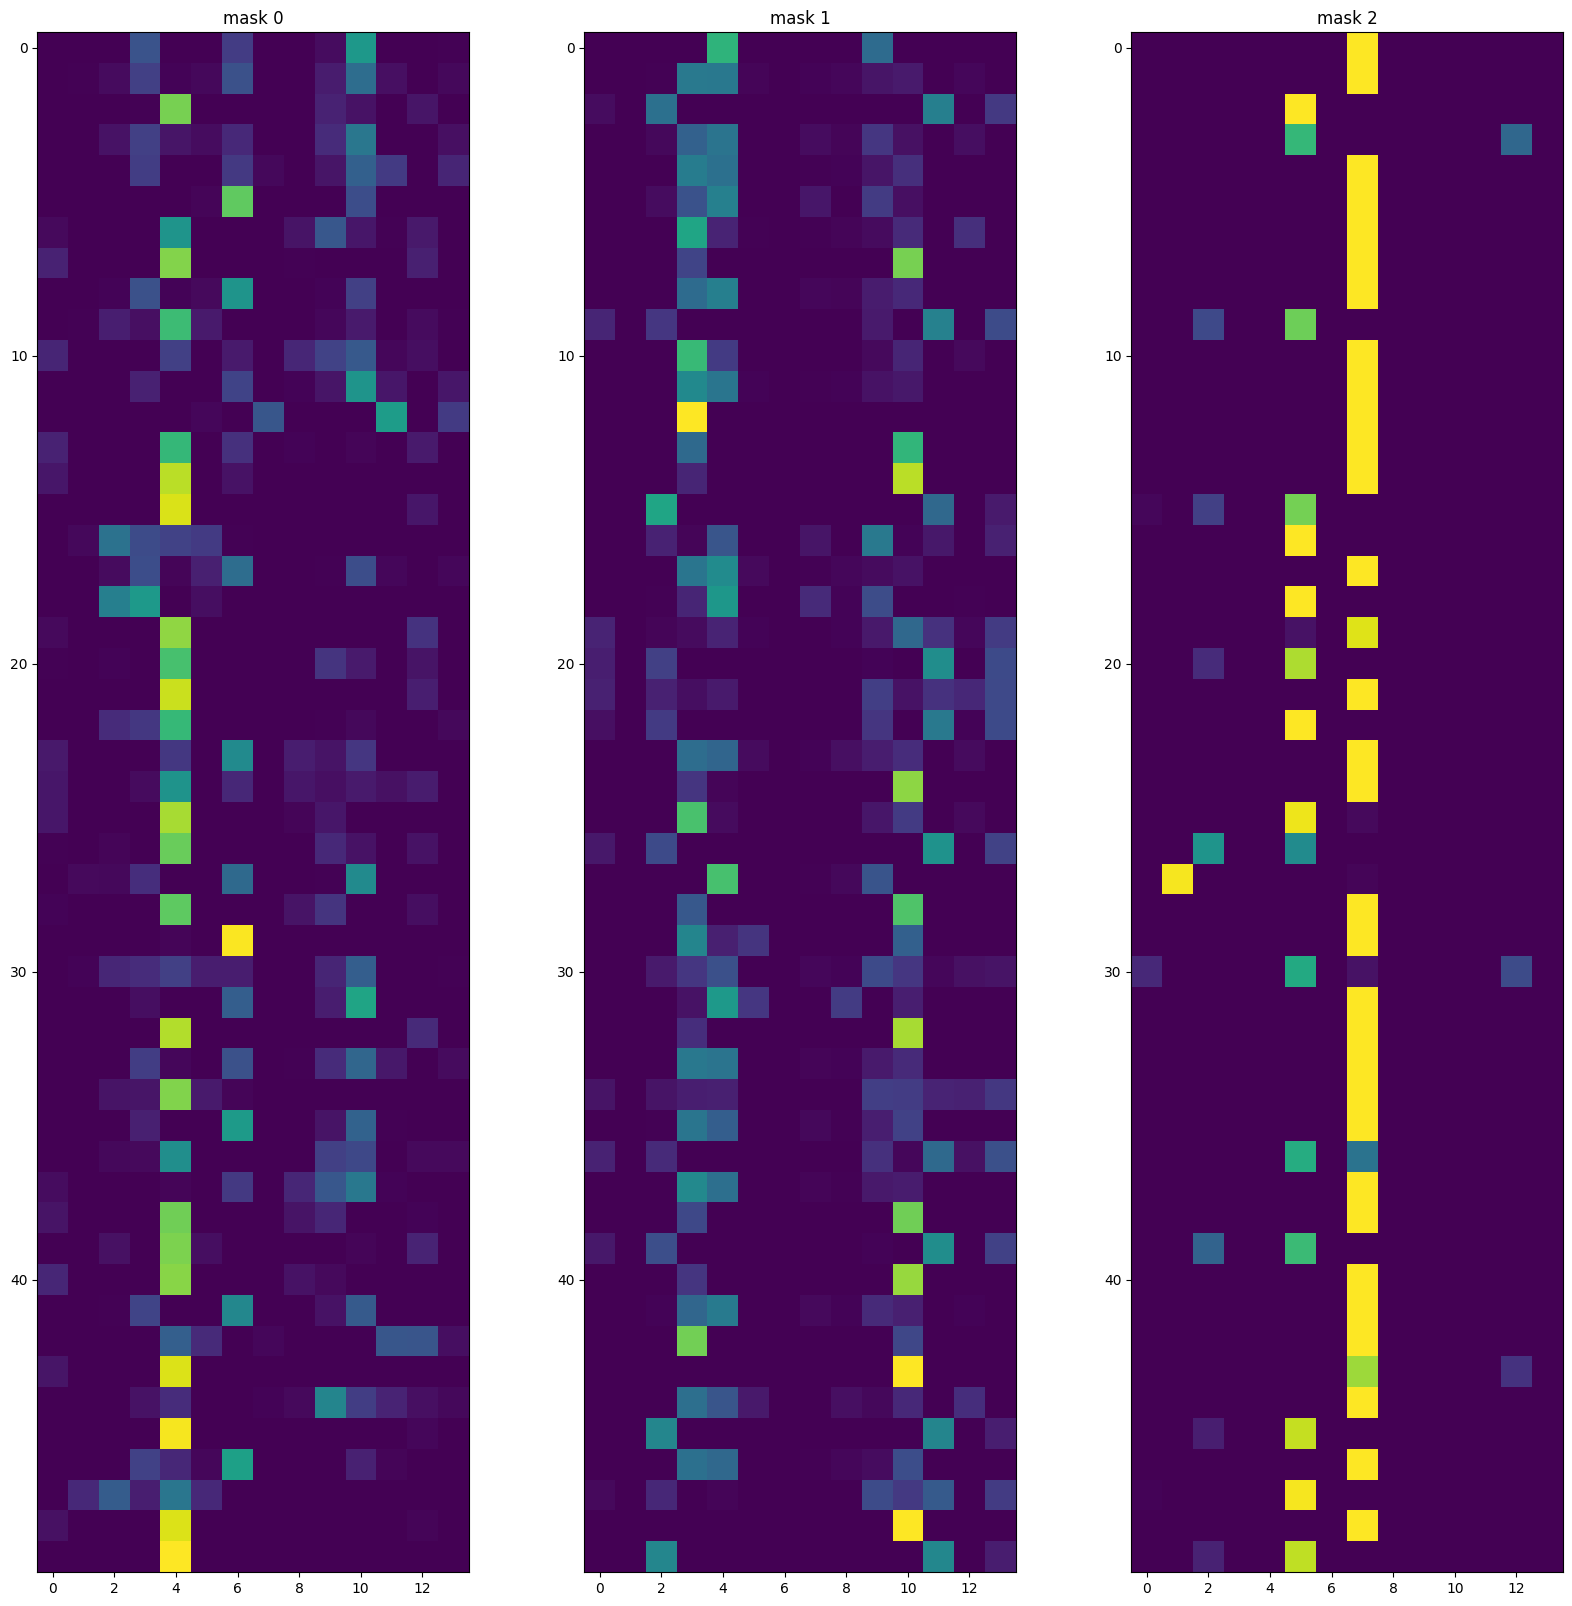

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
